C:\Users\João Marcelo\AppData\Local\Temp\ipykernel_4016\3031557073.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


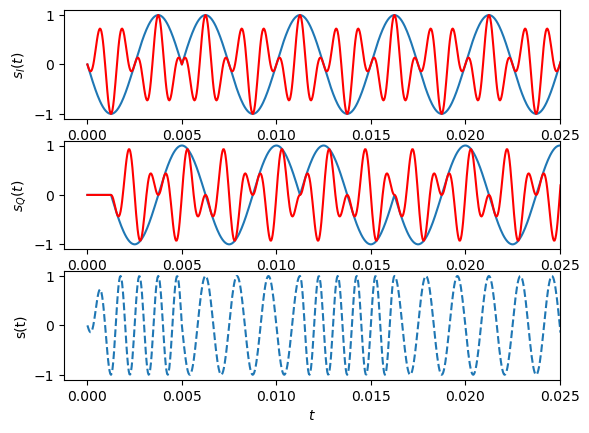

In [25]:
#Modulador e demodulador MSK. O plot do modulador mostra o sinal em passa-banda. A diferença do sinal original para o 
#demodulador está expresso na BER, feita em octave, e é tratada em pouquíssimas diferenças de bits.

import numpy as np
import matplotlib.pyplot as plt

def msk_mod(a, fc, OF, enable_plot = False):
   
    ak = 2*a-1 # 0->-1 1->+1
    ai = ak[0::2]; aq = ak[1::2] # dividir pares e ímpares
    L = 2*OF # duração do símbolo é o dobro da duração do bit
    
    #upsample por L 
    from scipy.signal import upfirdn, lfilter
    ai = upfirdn(h=[1], x=ai, up = L)
    aq = upfirdn(h=[1], x=aq, up = L)
    
    aq = np.pad(aq, (L//2,0), 'constant') # delay em Tb (L/2)
    ai = np.pad(ai, (0,L//2), 'constant') # igualar o tamanho dos vetores
    
    #filtros passa-baixa
    Fs = OF*fc;Ts = 1/Fs;Tb = OF*Ts
    t = np.arange(0,2*Tb+Ts,Ts)
    h = np.sin(np.pi*t/(2*Tb))# filtro LPF
    sI_t = lfilter(b = h, a = [1], x = ai) # banda básica em fase
    sQ_t = lfilter(b = h, a = [1], x = aq) # banda básica em quadratura
    
    t=np.arange(0, Ts*len(sI_t), Ts) # portadora
    sIc_t = sI_t*np.cos(2*np.pi*fc*t) #com portadora
    sQc_t = sQ_t*np.sin(2*np.pi*fc*t) #com portadora
    s_t =  sIc_t - sQc_t# sinal em banda passante
    
    if enable_plot:
        fig, (ax1,ax2,ax3) = plt.subplots(3, 1)
        
        ax1.plot(t,sI_t);ax1.plot(t,sIc_t,'r')
        ax2.plot(t,sQ_t);ax2.plot(t,sQc_t,'r')
        ax3.plot(t,s_t,'--')        
        ax1.set_ylabel('$s_I(t)$');ax2.set_ylabel('$s_Q(t)$')
        ax3.set_ylabel('s(t)')        
        ax1.set_xlim([-Tb,20*Tb]);ax2.set_xlim([-Tb,20*Tb])
        ax3.set_xlim([-Tb,20*Tb])
        ax1.set_xlabel('$t$');ax2.set_xlabel('$t$')
        ax3.set_xlabel('$t$')
        fig.show()
        
    result = dict()
    result['s(t)']=s_t;result['sI(t)']=sI_t;result['sQ(t)']=sQ_t;result['t']=t
    return result

def msk_demod(r,N,fc,OF):
    """
    MSK demodulator
    Parameters:
        r : received signal at the receiver front end
        N : number of symbols transmitted
        fc : carrier frequency in Hertz
        OF : oversampling factor (at least 4 is better)
    Returns:
        a_hat : detected binary stream
    """
    L = 2*OF # amostras em duração 2Tb
    Fs=OF*fc;Ts=1/Fs;Tb = OF*Ts; # Freq amostragem; durações
    t=np.arange(-OF, len(r) - OF)/Fs # tempo
    
    # senóides 
    x=abs(np.cos(np.pi*t/(2*Tb)));y=abs(np.sin(np.pi*t/(2*Tb)))
    
    u=r*x*np.cos(2*np.pi*fc*t) # multiplica a fase pelo meio-cosseno
    v=-r*y*np.sin(2*np.pi*fc*t) # multiplica a quadratura pelo meio-seno
    
    iHat = np.convolve(u,np.ones(L)) # integra em 2Tb
    qHat = np.convolve(v,np.ones(L)) # integra em 2Tb
  #  print('ihat antes', iHat, iHat.shape)
    iHat= iHat[L-1:-1-L:L]  # amostra no fim de cada símbolo
    qHat= qHat[L+L//2-1:-1-L//2:L] # amostra a cada L + L/2 amostra
  #  print('ihat dps', iHat, iHat.shape)
    a_hat = np.zeros(N)
    iHat=np.concatenate((iHat,a[len(a)-1]),axis=None)
    a_hat[0::2] = iHat > 0 # bits ímpares
    qHat=np.concatenate((qHat,a[len(a)-2]),axis=None)
    a_hat[1::2] = qHat > 0 # bits pares
    
    return a_hat



N = 100000 # Number of symbols to transmit
EbN0dB = np.arange(start=-4,stop = 11,step = 2) # Eb/N0 range em dB pra simulação
fc = 800 # freq portadora
OF = 32 # fator de oversampling

BER = np.zeros(len(EbN0dB)) # BER

a = np.random.randint(2, size=N) # símbolos aleatórios 0s e 1s
result = msk_mod(a,fc,OF,enable_plot=True) # MSK
s = result['s(t)']

#A primeira imagem refere-se a componente em fase do sinal.
#A segunda imagem refere-se a componente em quadratura do sinal.
#A terceira imagem é o MSK modulado

C:\Users\João Marcelo\AppData\Local\Temp\ipykernel_4016\1787287517.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.set_xlabel('$f-f_c$');ax.set_ylabel('PSD (dB/Hz)');ax.legend();fig.show()


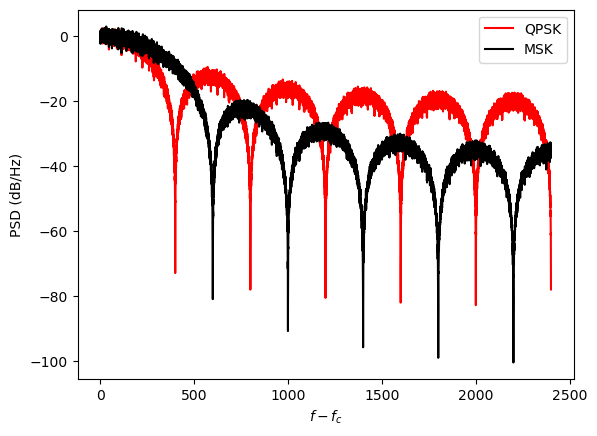

In [20]:
#Plot da PSD. Foi utilizado uma função qpsk_mod para fins de comparação. Todos os outros códigos foram adaptados do livro Digital Modulations using python
def qpsk_mod(a, fc, OF, enable_plot = False):
    """
    Modulate an incoming binary stream using conventional QPSK
    Parameters:
        a : input binary data stream (0's and 1's) to modulate
        fc : carrier frequency in Hertz
        OF : oversampling factor - at least 4 is better
        enable_plot : True = plot transmitter waveforms (default False)
    Returns:
        result : Dictionary containing the following keyword entries:
          s(t) : QPSK modulated signal vector with carrier i.e, s(t)
          I(t) : baseband I channel waveform (no carrier)
          Q(t) : baseband Q channel waveform (no carrier)
          t : time base for the carrier modulated signal
    """
    L = 2*OF # samples in each symbol (QPSK has 2 bits in each symbol)
    I = a[0::2];Q = a[1::2] #even and odd bit streams
    # even/odd streams at 1/2Tb baud
        
    from scipy.signal import upfirdn #NRZ encoder
    I = upfirdn(h=[1]*L, x=2*I-1, up = L)
    Q = upfirdn(h=[1]*L, x=2*Q-1, up = L)
    
    fs = OF*fc # sampling frequency 
    t=np.arange(0,len(I)/fs,1/fs)  #time base    
    
    I_t = I*np.cos(2*np.pi*fc*t);Q_t = -Q*np.sin(2*np.pi*fc*t)
    s_t = I_t + Q_t # QPSK modulated baseband signal
    
    if enable_plot:
        fig = plt.figure(constrained_layout=True)        
    
        from matplotlib.gridspec import GridSpec
        gs = GridSpec(3, 2, figure=fig)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[1, 0])
        ax4 = fig.add_subplot(gs[1, 1])
        ax5 = fig.add_subplot(gs[-1,:])  
              
        # show first few symbols of I(t), Q(t)
        ax1.plot(t,I)       
        ax2.plot(t,Q)
        ax3.plot(t,I_t,'r')
        ax4.plot(t,Q_t,'r')
        
        ax1.set_title('I(t)')
        ax2.set_title('Q(t)')
        ax3.set_title('$I(t) cos(2 \pi f_c t)$')
        ax4.set_title('$Q(t) sin(2 \pi f_c t)$')
        
        ax1.set_xlim(0,20*L/fs);ax2.set_xlim(0,20*L/fs)
        ax3.set_xlim(0,20*L/fs);ax4.set_xlim(0,20*L/fs)
        ax5.plot(t,s_t);ax5.set_xlim(0,20*L/fs);fig.show()
        ax5.set_title('$s(t) = I(t) cos(2 \pi f_c t) - Q(t) sin(2 \pi f_c t)$')
    
    result = dict()
    result['s(t)'] =s_t;result['I(t)'] = I;result['Q(t)'] = Q;result['t'] = t           
    return result

def plotWelchPSD(x,fs,fc,ax = None,color='b', label=None):
    """
    Plot PSD of a carrier modulated signal using Welch estimate
    Parameters:
        x : signal vector (numpy array) for which the PSD is plotted
        fs : sampling Frequency
        fc : center carrier frequency of the signal
        ax : Matplotlib axes object reference for plotting
        color : color character (format string) for the plot
    """
    import scipy.signal
    from numpy import log10
    nx = max(x.shape)
    na = 16 # fator médio
    w = scipy.signal.windows.hann(nx//na) 
    # janela de hanning e sem overlap
    f, Pxx = scipy.signal.welch(x,fs,window = w,noverlap=0)
    indices = (f>=fc) & (f<4*fc)   # plotar de fc até 4*fc
    Pxx = Pxx[indices]/Pxx[indices][0] # psd normalizada
    ax.plot(f[indices]-fc,10*log10(Pxx),color,label=label) 
def msk_psd():
    N=100000 # número de símbolos a transmitir
    fc=800;OF =8 # frequencia da portadora e fator de oversampling
    fs = fc*OF # freq. sampling
    a = np.random.randint(2, size=N) # símbolos aleatórios de 0s e 1s
    s_qpsk = qpsk_mod(a,fc,OF)['s(t)'] # QPSK para comparação
    s_msk = msk_mod(a,fc,OF)['s(t)'] # sinal MSK
# plotar a PSD dos sinais modulados
    fig, ax = plt.subplots(1, 1)
    plotWelchPSD(s_qpsk,fs,fc,ax = ax,color = 'r',label='QPSK')
    plotWelchPSD(s_msk,fs,fc, ax = ax,color = 'k',label='MSK')
    ax.set_xlabel('$f-f_c$');ax.set_ylabel('PSD (dB/Hz)');ax.legend();fig.show()
msk_psd()